# **Non-Max Supression**

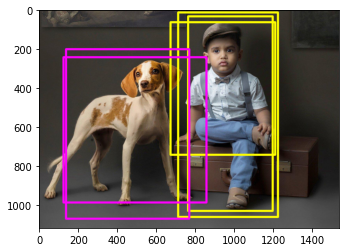

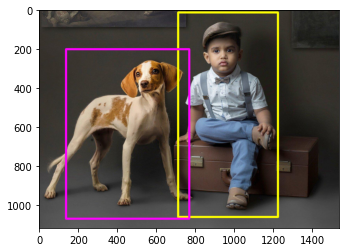

#**Import all the Required Libraries**

In [ ]:
# Import required Modules
import cv2
import torch
import matplotlib.pyplot as plt
from IPython.display import Image

#**Download a sample image**

In [ ]:
! gdown "https://drive.google.com/uc?id=12oEaqyR7ILaf0U56q7Ur7uIBUNKavYXf&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=12oEaqyR7ILaf0U56q7Ur7uIBUNKavYXf&confirm=t
To: c:\Courses\2025\Udemy\YOLOv11-v12-Object-Detection-Web-Apps\Person_and_Dog.jpg

  0%|          | 0.00/202k [00:00<?, ?B/s]
100%|██████████| 202k/202k [00:00<00:00, 10.2MB/s]


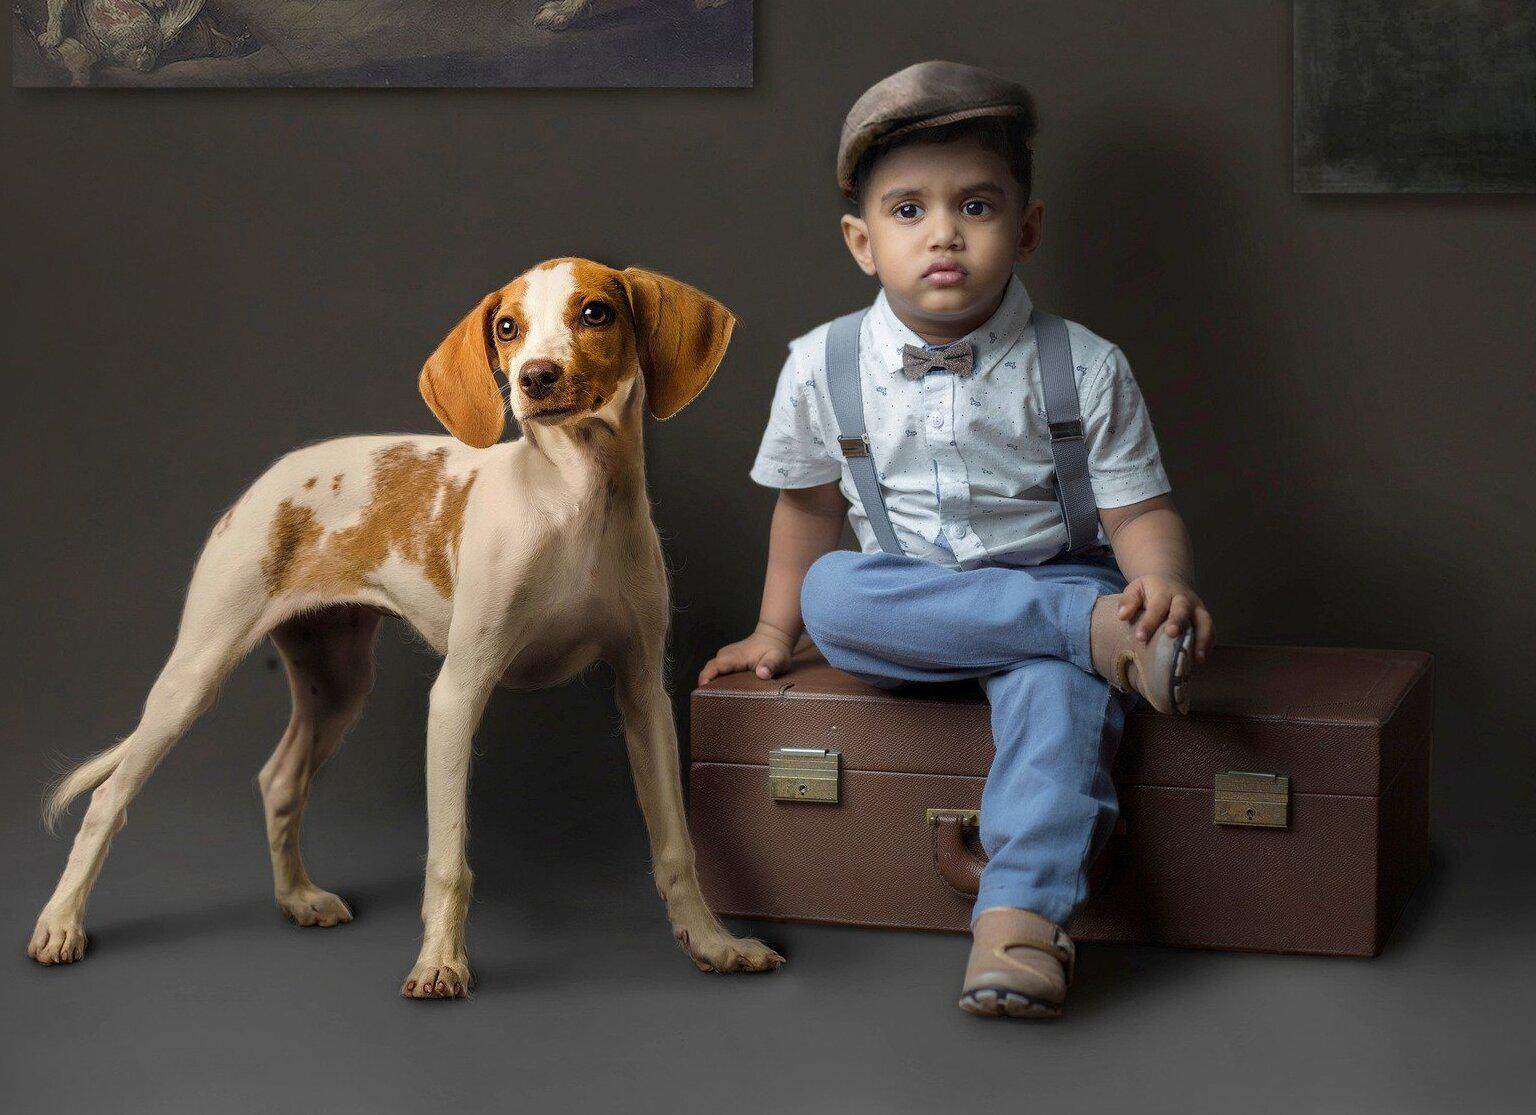

In [ ]:
Image("/content/Person_and_Dog.jpg")

#**Download the Bounding Box Coordinates, Confidence Score and Class Name, for each object in the Image**

In [ ]:
!gdown "https://drive.google.com/uc?id=1tFykOfnJcnZJ1WC3VAqrAA1jA20RvoBc&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1tFykOfnJcnZJ1WC3VAqrAA1jA20RvoBc&confirm=t
To: /content/Predictions.txt
100% 117/117 [00:00<00:00, 558kB/s]


#**Read the predictions.txt file line by line**

In [ ]:
def read_predictions(filepath):
    with open(filepath) as f:
        return f.readlines()

In [ ]:
prediction = read_predictions('/content/Predictions.txt')

In [ ]:
prediction

['673,62,1209,740,0,0.89\n',
 '763,32,1196,1027,0,0.95\n',
 '712,12,1223,1058,0,0.99\n',
 '125,241,857,984,1,0.90\n',
 '138,200,769,1067,1,0.95']

#**Preprocessing**

In [ ]:
def process_predictions(predictions):
    processed_predictions = []
    for prediction in predictions:
        prediction = prediction.split(',')
        prediction = [
            float(elem.replace('\n', '')) if prediction.index(elem) == 5
            else int(elem.replace('\n', ''))
            for elem in prediction
        ]
        processed_predictions.append(prediction)
    return processed_predictions

In [ ]:
predictions = process_predictions(prediction)

In [ ]:
predictions

[[673, 62, 1209, 740, 0, 0.89],
 [763, 32, 1196, 1027, 0, 0.95],
 [712, 12, 1223, 1058, 0, 0.99],
 [125, 241, 857, 984, 1, 0.9],
 [138, 200, 769, 1067, 1, 0.95]]

#**Draw the Bounding Boxes around each object in the image**

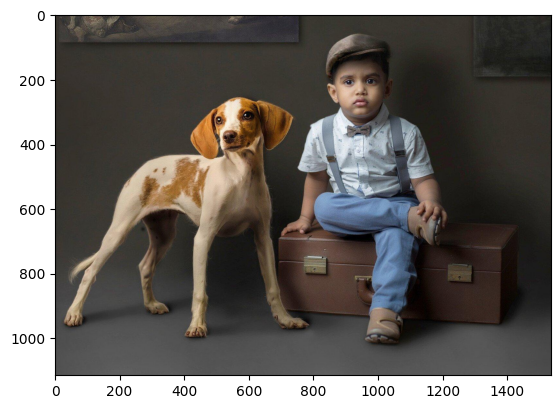

In [ ]:
img = cv2.imread('/content/Person_and_Dog.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [ ]:
Color_map = {
    0:(255,255,0), # R,G,B
    1:(255,0,255)
}

def draw_boxes(img, predictions):
    for prediction in predictions:
        color = Color_map[prediction[4]]
        cv2.rectangle(img, prediction[0:2], prediction[2:4], color, 10)
    return img


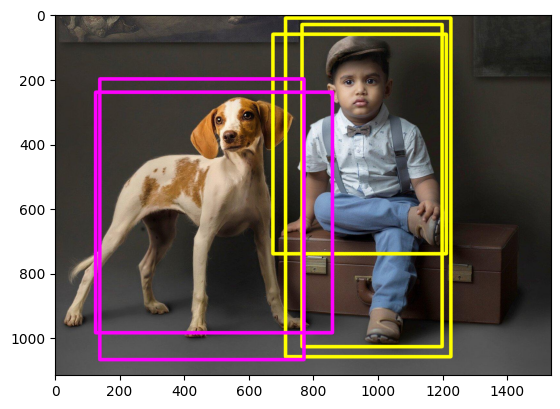

In [ ]:
img = draw_boxes(img, predictions)
plt.imshow(img)
plt.show()

#**Calculate IoU**

We compare the box1 which is the bounding box with the highest confidence score with all the other bounding boxes of the same class with low confidence score than box1

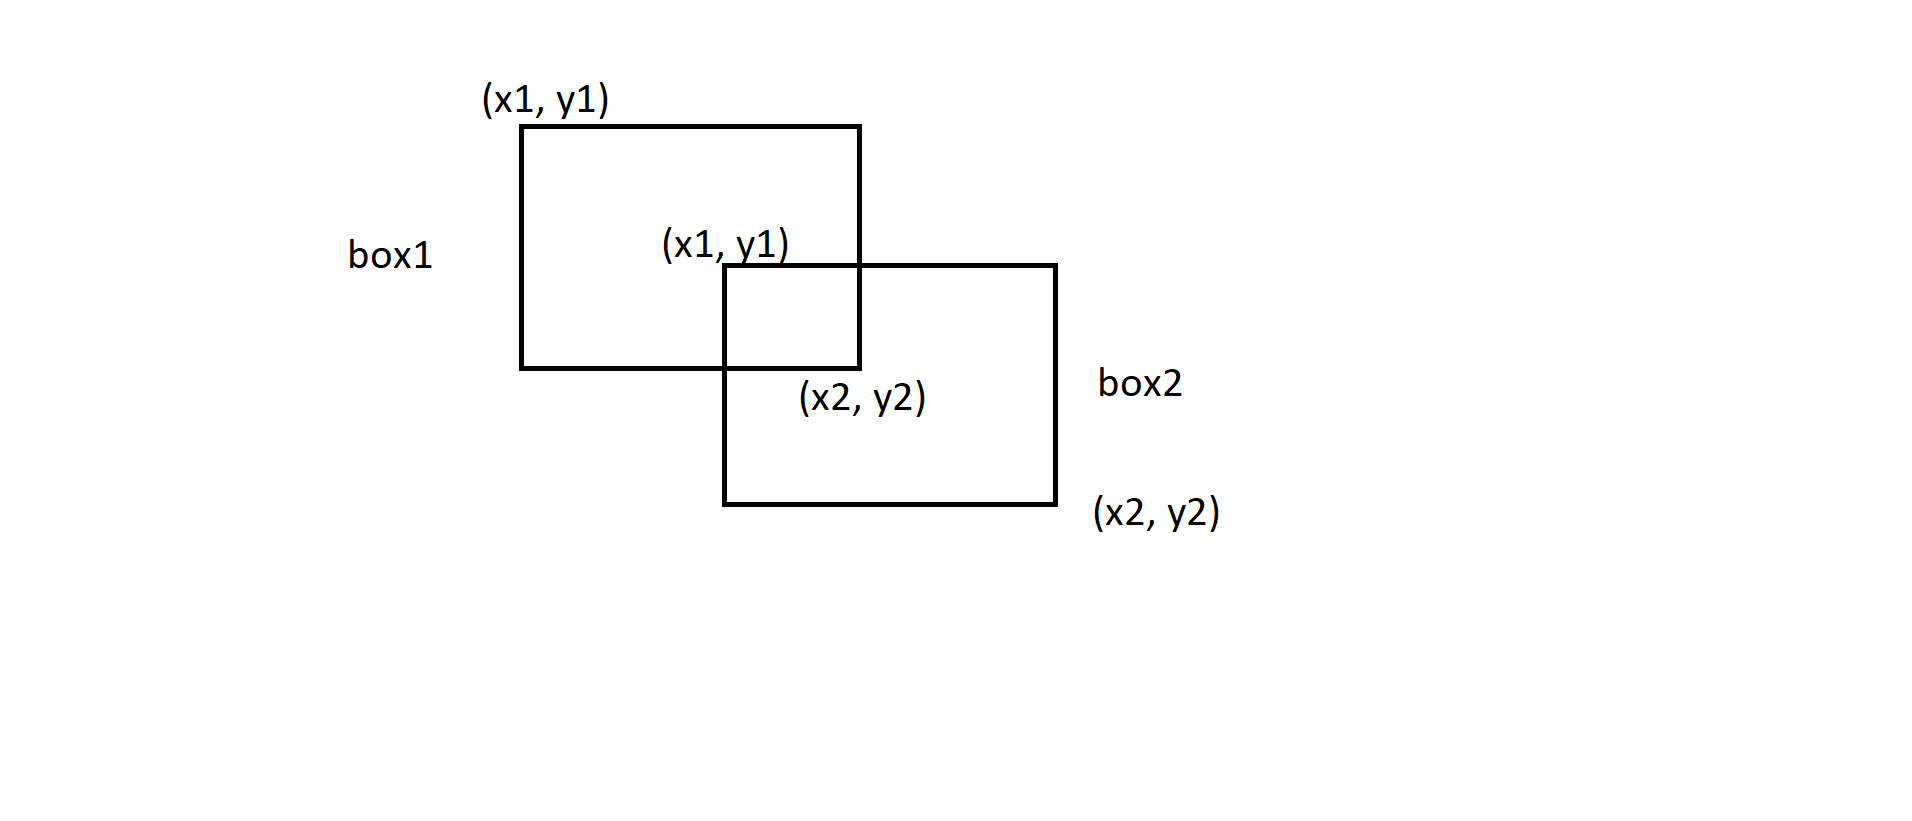

In [ ]:
def calculate_IOU(box1, box2):

    box1_x1 = box1[..., 0:1]
    box1_y1 = box1[..., 1:2]
    box1_x2 = box1[..., 2:3]
    box1_y2 = box1[..., 3:4]

    box2_x1 = box2[..., 0:1]
    box2_y1 = box2[..., 1:2]
    box2_x2 = box2[..., 2:3]
    box2_y2 = box2[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)

    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    area_of_intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    area_of_union = box1_area + box2_area - area_of_intersection

    return area_of_intersection / area_of_union


#**Calculate the NMS**

In [ ]:
# Creating Non Max Supression
def non_max_supression(boxes, conf_threshold=0.10, iou_threshold=0.10):
    filtered_boxes = []
    final_boxes = []
    sorted_boxes = sorted(boxes, reverse=True, key = lambda x : x[5])
    for box in sorted_boxes:
        if box[5] > conf_threshold:
            filtered_boxes.append(box)
    count = 0
    while len(filtered_boxes) > 0:
        count += 1
        current_box = filtered_boxes.pop(0)
        for box in filtered_boxes:
            if current_box[4] == box[4]:
                iou = calculate_IOU(torch.Tensor(current_box[:4]), torch.Tensor(box[:4]))
                if iou > iou_threshold:
                    filtered_boxes.remove(box)
        final_boxes.append(current_box)
    return final_boxes


In [ ]:
nmspredictions = non_max_supression (predictions)

In [ ]:
nmspredictions

[[712, 12, 1223, 1058, 0, 0.99], [138, 200, 769, 1067, 1, 0.95]]

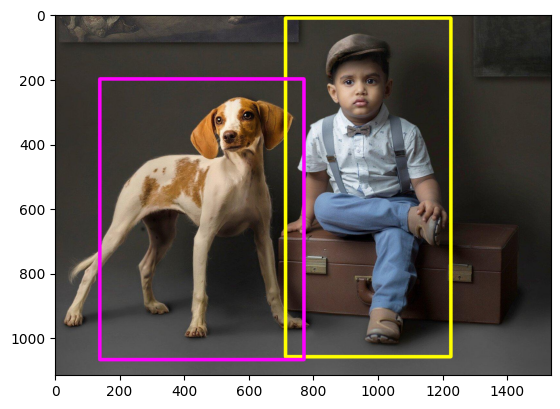

In [ ]:
img = cv2.imread('/content/Person_and_Dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_boxes(img, nmspredictions)
plt.imshow(img)
plt.show()